In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")


/home/userful/Ali/open60fps8k/video_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set path to your CSV files
csv_dir = "/home/userful/Ali/open60fps8k/Analysis/Analysis/*.csv"  # Replace with your actual path

# Get sorted list of CSV files
all_files = sorted(glob.glob(csv_dir))

# Initialize list to store DataFrames
dfs = []

for file in all_files:
    try:
        if 'vmaf' in file:
            continue
        # Extract video number from filename (assuming format: 000_videoname.csv)
        filename = os.path.basename(file)
        video_number = int(filename.split('_')[0])  # First part is numeric
        
        # Read CSV and add video number column
        df = pd.read_csv(file)
        df['video_number'] = video_number
        
        dfs.append(df)
        
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Verify results
print(f"Combined DataFrame shape: {combined_df.shape}")
print("Unique video numbers:", combined_df['video_number'].unique())

Combined DataFrame shape: (61199, 21)
Unique video numbers: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]


In [3]:
combined_df.head(10)

,Frame,SI,TI,Contrast,Sharpness,Blockiness,TextureComplexity,ColorVar_U,ColorVar_V,Colorfulness,...,TemporalActivity,Entropy,EntropyDiff,MotionIntensityDiff,EdgeDirectionality,AvgMotionXAxis,AvgMotionYAxis,StdMotionXAxis,StdMotionYAxis,video_number
0,0,40.0630,0.0000,189.125,70.3125,63.3438,0.0171,32.3438,123.6875,13.4453,...,0.0000,6.0492,0.0000,0.0000,4.0480,0.0000,0.0000,0.0000,0.0000,0
1,1,40.2988,4.9492,188.875,68.0000,63.1250,0.0121,32.0312,123.0000,13.4141,...,20.6250,6.0325,0.0166,1.8750,4.0150,0.2247,0.3674,0.1087,0.0829,0
2,2,40.3030,5.6094,188.625,66.9375,63.0000,0.0106,31.8438,122.0000,13.3750,...,23.7031,6.0201,0.0124,2.2129,3.9964,0.5034,0.1620,0.1726,0.1733,0
3,3,39.2118,11.5156,188.375,66.6875,62.9062,0.0109,31.7812,122.1875,13.3906,...,102.1250,6.0173,0.0028,2.9277,3.9995,0.7808,0.7510,0.2515,0.3083,0
4,4,38.5201,18.0938,188.250,68.2500,62.9688,0.0139,31.7812,122.1875,13.3828,...,240.6250,6.0261,0.0089,4.1562,4.0269,1.2939,1.2490,0.2319,0.2773,0
5,5,39.1027,20.1875,188.500,66.4375,62.9375,0.0105,31.6094,121.5625,13.3516,...,298.7500,6.0243,0.0018,4.5898,3.9966,1.2031,1.4893,0.2915,0.3115,0
6,6,40.5118,13.0469,188.625,66.2500,63.0000,0.0098,31.7344,121.5625,13.3594,...,134.6250,6.0245,0.0001,3.0254,3.9820,0.6670,0.6748,0.3428,0.1924,0
7,7,40.5610,6.8242,188.750,65.7500,63.0000,0.0090,31.8281,122.2500,13.3906,...,36.1250,6.0253,0.0008,2.2422,3.9730,0.5269,0.1794,0.1498,0.3511,0
8,8,40.3082,8.0234,189.000,65.0000,63.0000,0.0080,31.8281,122.0625,13.3828,...,51.2812,6.0315,0.0062,2.2773,3.9574,0.3979,0.5107,0.2529,0.1936,0
9,9,40.1801,12.7891,189.125,65.5625,63.1250,0.0090,32.0625,122.0000,13.3672,...,128.2500,6.0446,0.0132,3.1523,3.9753,0.8198,0.6440,0.3508,0.1088,0


In [4]:
# Custom aggregation functions
def linear_trend(s):
    x = np.arange(len(s))
    return np.polyfit(x, s, 1)[0] if len(s) > 1 else np.nan

def entropy(s):
    return skew(s) * kurtosis(s)  # Custom complexity measure

# Define the columns you want to keep

columns_to_use = [

 'SI',
 'TI',
 'TextureComplexity',
 'Colorfulness',
 'Entropy',
 'AvgMotionXAxis',
 'AvgMotionYAxis',
 'video_number'
]

# Filter the DataFrame
filtered_df = combined_df[columns_to_use].copy()

# Confirm 'video_number' is present
assert 'video_number' in filtered_df.columns

# Define numeric columns (excluding 'video_number')
numeric_cols = filtered_df.select_dtypes(include=np.number).columns.difference(['video_number']).tolist()


# Define comprehensive aggregations
def safe_skew(x):
    if len(x) < 3 or x.std() < 1e-8:
        return np.nan
    return skew(x, bias=False)

def safe_kurtosis(x):
    if len(x) < 4 or x.std() < 1e-8:
        return np.nan
    return kurtosis(x, bias=False)

def stabilized_entropy(x):
    hist = np.histogram(x, bins='auto')[0].astype(float)
    hist += 1e-12  # Prevent zero probabilities
    hist /= hist.sum()
    return -np.sum(hist * np.log(hist))

def safe_hurst(x):
    if len(x) < 10 or np.std(x) < 1e-8:
        return np.nan
    return np.log(np.std(x) + 1e-12) / np.log(len(x))

def robust_autocorr(x):
    if len(x) < 2 or x.std() < 1e-8:
        return np.nan
    return x.autocorr(lag=1)

# Create the aggregation dictionary
agg_config = {
    col: [
        ('mean', lambda x: np.nanmean(x)),
        ('std', lambda x: np.nanstd(x)),
        ('range', lambda x: np.nanmax(x) - np.nanmin(x)),
        ('skew', safe_skew),
        ('kurt', safe_kurtosis),
        ('median', lambda x: np.nanmedian(x)),
        ('mad', lambda x: np.nanmean(np.abs(x - np.nanmean(x)))),
        ('trend', linear_trend),
        ('autocorr', robust_autocorr),
        ('fft1', lambda x: np.abs(np.fft.fft(x.fillna(0).values)[1]) if len(x) > 1 else np.nan),
        ('hurst', safe_hurst),
        ('nonlin', lambda x: np.nanmean(np.diff(x)**2))
    ]
    for col in numeric_cols
}

# Perform aggregation
agg_features = filtered_df.groupby('video_number').agg(agg_config)


# Flatten column names
agg_features.columns = [f"{col}_{stat}" for col, stat in agg_features.columns]

# Clean and clip the data
agg_features = agg_features.replace([np.inf, -np.inf], np.nan)
agg_features = agg_features.fillna(agg_features.mean())
agg_features = agg_features.clip(lower=agg_features.quantile(0.01),
                                 upper=agg_features.quantile(0.99), axis=1)


In [5]:
agg_features.head(10)

,AvgMotionXAxis_mean,AvgMotionXAxis_std,AvgMotionXAxis_range,AvgMotionXAxis_skew,AvgMotionXAxis_kurt,AvgMotionXAxis_median,AvgMotionXAxis_mad,AvgMotionXAxis_trend,AvgMotionXAxis_autocorr,AvgMotionXAxis_fft1,...,TextureComplexity_range,TextureComplexity_skew,TextureComplexity_kurt,TextureComplexity_median,TextureComplexity_mad,TextureComplexity_trend,TextureComplexity_autocorr,TextureComplexity_fft1,TextureComplexity_hurst,TextureComplexity_nonlin
video_number,,,,,,,,,,,,,,,,,,,,,
0,-0.036680,2.455816,32.4453,0.064704,6.254662,0.06260,1.262927,0.000437,0.893469,154.061462,...,0.072600,1.388828,2.285183,0.01880,0.011278,0.000020,0.946434,2.470709,-0.660005,2.300190e-05
1,-0.040785,0.291782,3.2139,-2.783599,14.119865,-0.00130,0.138463,0.000068,0.931676,31.388619,...,0.226600,0.927038,0.774492,0.22255,0.040636,0.000183,0.996262,16.368993,-0.477488,1.663194e-05
2,0.072788,0.145204,0.7427,-0.657436,0.147708,0.09300,0.114527,-0.000284,0.836796,10.636022,...,0.008800,-0.963747,0.585432,0.37460,0.001454,0.000005,0.977913,0.551759,-0.983203,1.517863e-07
3,0.199332,3.500362,38.9844,0.078242,9.300141,0.27430,2.096684,-0.003546,0.934696,151.621479,...,0.402334,-0.071787,-1.193689,0.51370,0.085737,-0.000291,0.972767,31.391932,-0.364238,5.163270e-04
4,0.075629,0.236347,1.4531,-0.423465,1.335028,0.09140,0.166471,-0.000048,0.938085,28.647538,...,0.029400,0.085316,-1.627503,0.53385,0.008768,-0.000027,0.979847,1.074564,-0.732501,3.432938e-06
5,0.102079,0.214946,1.6821,2.664009,9.543210,0.06095,0.129549,-0.000578,0.921447,40.226176,...,0.264500,2.712296,7.413292,0.44000,0.023978,-0.000117,0.988815,8.020217,-0.512981,3.131816e-05
6,0.015560,1.127742,10.5039,0.028064,4.194582,-0.00195,0.790147,0.000539,0.942288,39.545711,...,0.228200,-0.018236,-0.600931,0.52955,0.035450,-0.000009,0.970198,3.118232,-0.494303,1.062319e-04
7,0.016756,0.024984,0.1479,0.134769,0.073918,0.01670,0.019610,0.000001,0.237974,0.283837,...,0.095400,6.086216,61.908025,0.56380,0.003952,-0.000011,0.699935,0.964563,-0.774257,2.445404e-05
8,0.387643,0.299582,1.2339,0.308121,-0.986938,0.36815,0.259178,-0.001197,0.989341,104.452723,...,0.085200,0.491125,-0.054397,0.08695,0.012392,0.000033,0.995714,4.824291,-0.660597,1.802020e-06


In [6]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_features)
features_scaled_df = pd.DataFrame(features_scaled, columns=agg_features.columns)

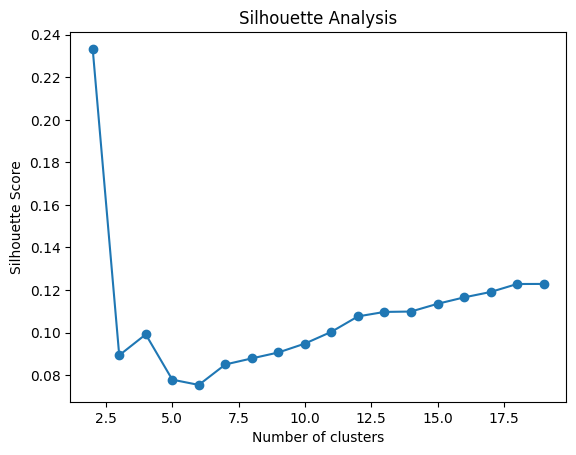

In [7]:

sil_scores = []
K_range = range(2, 20)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k).fit(features_scaled)
    labels = model.fit_predict(features_scaled)
    sil = silhouette_score(features_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


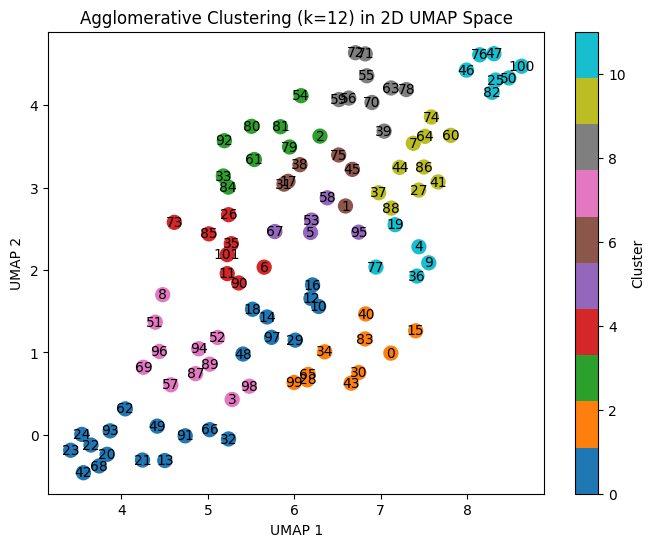

In [9]:

# Step 1: Reduce dimensions for clustering
umap_reducer = umap.UMAP(n_components=10, random_state=0)
features_reduced = umap_reducer.fit_transform(features_scaled)

# Step 2: Perform clustering
final_k = 12  # or your preferred number of clusters
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Step 3: UMAP again for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=100)
plt.title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
for i, video_id in enumerate(agg_features.index):  # assumes index is video_number
    plt.text(X_2d[i, 0], X_2d[i, 1], str(video_id), fontsize=10, ha='center', va='center')

plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Start with a DataFrame that includes video numbers and their assigned clusters
video_cluster_df = pd.DataFrame({
    'video_number': agg_features.index,
    'cluster': labels
})

# Stratified split by cluster
train_videos, test_videos = train_test_split(
    video_cluster_df,
    test_size=0.2,
    stratify=video_cluster_df['cluster'],
    random_state=0
)
train_video_ids = train_videos['video_number'].values
test_video_ids = test_videos['video_number'].values



In [20]:
print("Training video IDs:", train_video_ids)

Training video IDs: [ 93   5  14  17  92  23  39  78  11  97  91   2  82  33  75  26  96  79
   8  54  56  89  52  45  71  66  30  59  53   4  99  21  70  90  10  51
  29  65  57  37  32  18  84  40 100  50  15  19  81   9  74  49  25  31
  27  68  60  42  43  95  86  47  38  88  62  46  85  73  98  20  36  64
  35  67  44   3  69  16   0  63  28]


In [22]:
print("Testing video IDs:", test_video_ids)

Testing video IDs: [ 41  72  80  24 101  76  77  12  22  61  13  48  34  83   6   1   7  87
  55  58  94]


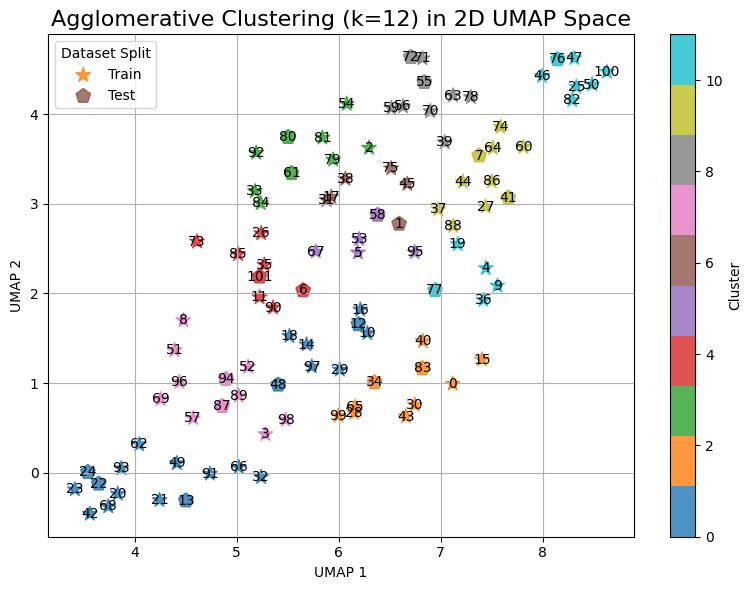

In [ ]:
import matplotlib.pyplot as plt

# Masks for train and test
is_train = agg_features.index.isin(train_video_ids)
is_test = ~is_train

plt.figure(figsize=(8, 6))

# Plot TRAIN videos (circle marker: '*')
plt.scatter(
    X_2d[is_train, 0],
    X_2d[is_train, 1],
    c=labels[is_train],
    cmap='tab10',
    s=120,
    marker='*',
    alpha=0.8,
    label='Train'
)

# Plot TEST videos (triangle marker: 'p')
plt.scatter(
    X_2d[is_test, 0],
    X_2d[is_test, 1],
    c=labels[is_test],
    cmap='tab10',
    s=120,
    marker='p',
    alpha=0.8,
    label='Test'
)

plt.title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space', fontsize=16)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
plt.legend(title='Dataset Split', fontsize=10)
plt.grid(True)
plt.tight_layout()
for i, video_id in enumerate(agg_features.index):  # assumes index is video_number
    plt.text(X_2d[i, 0], X_2d[i, 1], str(video_id), fontsize=10, ha='center', va='center')
plt.show()


In [35]:
df_split = video_cluster_df.copy()

# Add 'split' column based on train/test membership
df_split['split'] = df_split['video_number'].apply(
    lambda x: 'train' if x in train_video_ids else 'test'
)

df_split.to_csv('10s_video_splits.csv', index=False)
